# Personal Information
Name: Robin van den Berg

StudentID: 11317345

Email: [**robin.vanden.berg@student.uva.nl**](robin.vanden.berg@student.uva.nl)

Submitted on: 15-03-2023

# Data Context
**In this section you should introduce the datasources and datasets which you will be working with. Explain where they are from as well as their domain. Give an overview of what the context of the data is. You should not spend more than 1 to 2 paragraphs here as the core information will be in the next section.**

The data presented in this EDA is from Elsevier and is named Canary. The dataset is a subset of the Embase database. The Embase database is a biomedical research database maintained by the published Elsevier. The datbase is indexed by Emtree indexing terms, Elsevier’s authoritative life science thesaurus. The dataset contains the abstracts, keywords, titles and some supplemental information about articles present in this database in combination with the Emtree terms that are linked in to articles.

In this project, the Emtree terms are the labels that we want to assign to the papers. The Emtree terms are polyhierarchical, meaning that we have multiple tree structures that link the terms, while terms can still occur in two (or more) hierarchies at the same time. The Emtree terms index the entire text and pose a multilabel classification problem where the labels are not independent.

# Data Description

**Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**

As you can see, you are in a jupyter notebook environment here. This means that you should focus little on writing text and more on actually exploring your data. If you need to, you can use the amsmath environment in-line: $e=mc^2$ or also in separate equations such as here:

\begin{equation}
    e=mc^2 \mathrm{\space where \space} e,m,c\in \mathbb{R}
\end{equation}

Furthermore, you can insert images such as your data aggregation diagrams like this:

![image](example.png)

In [41]:
# Imports
import ast
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
sys.path.append(
  os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader

In [20]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data Loading

In [22]:
loc_dict = {
    'train': '../data/raw/canary/set_B_train_kw.csv',
    'val': '../data/raw/canary/set_B_val_kw.csv',
    'test': '../data/raw/canary/set_B_test_kw.csv',
    'xml':  '../data/raw/canary/original_xml_files/20210210_11422_194_1.xml',
    'xml_csv':  '../data/raw/canary/original_xml_files/all_articles_diff_labels.csv'
}
data_loader = DataLoader(loc_dict)

In [23]:
data_df = data_loader.load_xml_csv()

### Analysis 1: 
Explore content of the data. What is in there, and what are the mistakes.

Side note: The data was originally structured as separate XML files. This files have subsequently been parsed to csv, extracting the information that is likely to be useful and that we want to use for the research.

In [24]:
# what does the data look like?
print(f"The shape of the data: {data_df.shape}")
print(f"The columns that we have for each article: \n {data_df.columns.tolist()}")
print(f"A sample of the data: \n{data_df.head()}")

The shape of the data: (121369, 65)
The columns that we have for each article: 
 ['file_name', 'pui', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals', 'num_refs', 'date-delivered', 'labels_m', 'labels_a', 'human', 'mouse', 'rat', 'nonhuman', 'controlled study', 'animal experiment', 'animal tissue', 'animal model', 'animal cell', 'major clinical study', 'clinical article', 'case report', 'multicenter study', 'systematic review', 'meta analysis', 'observational study', 'pilot study', 'longitudinal study', 'retrospective study', 'case control study', 'cohort analysis', 'cross-sectional study', 'diagnostic test accuracy study', 'double blind procedure', 'crossover procedure', 'single blind procedure', 'adult', 'aged', 'middle aged', 'child', 'adolescent', 'young adult', 'very elderly', 'infant', 'school child', 'newborn', 'preschool child', 'embryo', 'fetus', 'male', 'female', 'human cell', 'human tissue', 'normal human', 'human experiment', 'phase 2 c

In [25]:
# check the missing data for each column
percent_missing = data_df.isnull().sum() * 100 / len(data_df)

print(percent_missing)

file_name                          0.000000
pui                                0.000000
title                              0.000000
keywords                          18.167736
abstract                           3.343523
abstract_2                        99.032702
authors                            0.000000
organization                       0.000000
chemicals                         39.180516
num_refs                           0.632781
date-delivered                     0.000000
labels_m                           4.290222
labels_a                           3.336931
human                              0.000000
mouse                              0.000000
rat                                0.000000
nonhuman                           0.000000
controlled study                   0.000000
animal experiment                  0.000000
animal tissue                      0.000000
animal model                       0.000000
animal cell                        0.000000
major clinical study            

In [32]:
# see structure of author and organisation information
data_df['authors'] = data_df['authors'].apply(lambda x: ast.literal_eval(x))
data_df['organization'] = data_df['organization'].apply(lambda x: ast.literal_eval(x))

### Visualise the structure of the labels

In [35]:
label_structure_df = pd.read_csv('../data/raw/canary/original_xml_files/paulas_labels.csv', sep=';')

In [36]:
label_structure_df

,human,0,organism studied
0,mouse,0,organism studied
1,rat,0,organism studied
2,nonhuman,0,organism studied
3,controlled study,1,controlled study
4,animal experiment,2,animal study type
5,animal tissue,2,animal study type
6,animal model,2,animal study type
7,animal cell,2,animal study type
8,major clinical study,3,human study type (clinical work)
9,clinical article,3,human study type (clinical work)


### Evaluate the occurrence and the co-occurrence of the different labels 


In [37]:
def get_labels(row):
    """De-onehot encode a row."""
    return(list(row.index[row==1]))

In [ ]:
# get all labels in separate dataframe
label_columns = data_df.loc[:, ~data_df.columns.isin(['file_name', 'pui', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals', 'num_refs', 'date-delivered', 'labels_m', 'labels_a'])]

D:\Users\bergr2\AppData\Local\Temp\ipykernel_2560\1560887703.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_df.corr()


<Axes: >

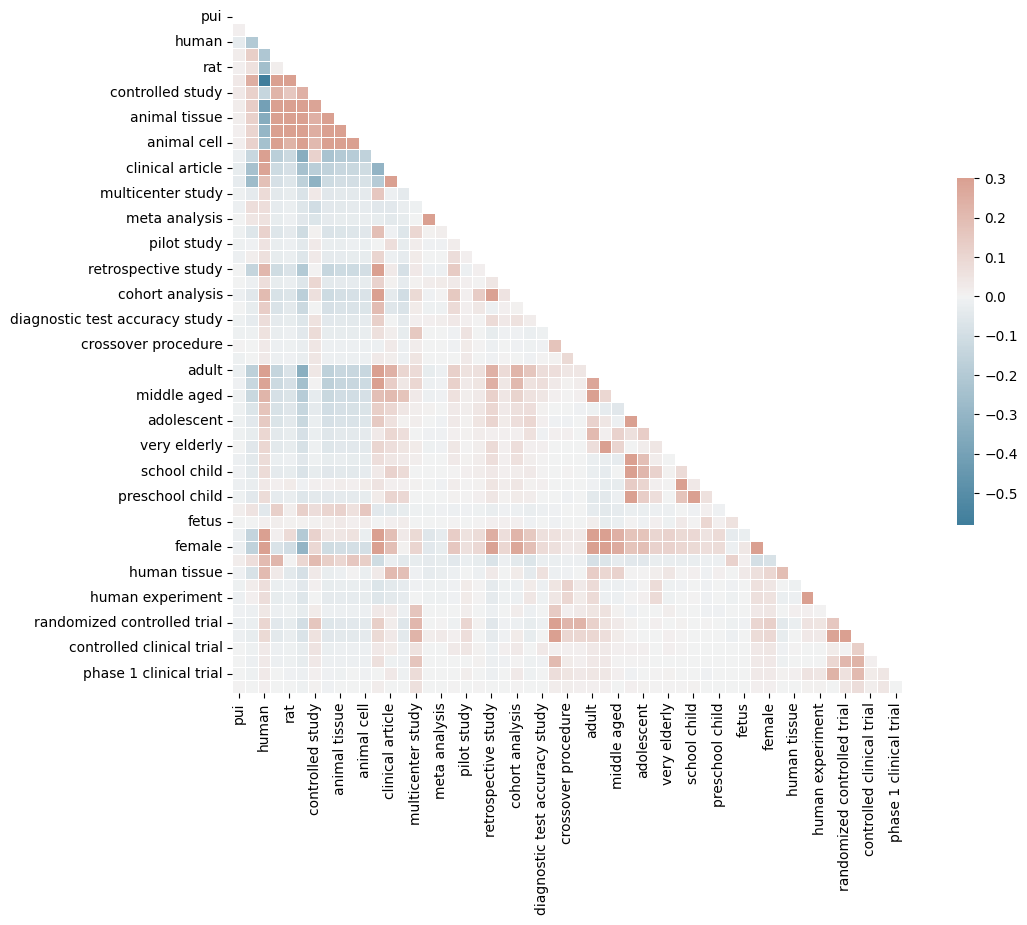

In [42]:
# inspect correlation between labels
corr = data_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [43]:
def collect_pairs(lines, combination_size):
    """Count the co-occurrences of labels."""
    pair_counter = Counter()
    for line in lines:
        unique_tokens = sorted(set(line))  # exclude duplicates in same line and sort to ensure one word is always before other
        combos = combinations(unique_tokens, combination_size)
        pair_counter += Counter(combos)
    return pair_counter

In [ ]:
# get all the label combinations
label_columns['label'] = label_columns.apply(lambda row:get_labels(row[label_columns.columns]), axis=1)
all_label_combinations = label_columns['label'].to_list()

In [ ]:
# check the 30 most occurring label combinations
pairs = collect_pairs(all_label_combinations, combination_size=3)
pairs.most_common(30)

### Check the occurrence and co-occurrence of different author assigned keywords

### Check the author occurrences

### Clean text data

In [5]:
# ...

### Check the correlation of the labels with the keywords and the authors

### Check the KNN capabilities for assigning multi-labels based on sematic similarity